In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normal Linear Regression

In [2]:
from linear_models import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

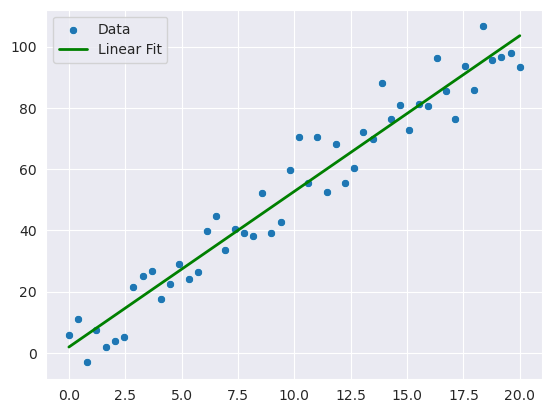

In [3]:
x = np.linspace(0, 20, 50)
y = 5 * x + 3 + np.random.randn(50) * 7

mdl = LinearRegression().fit(x.reshape(-1, 1), y)
x_reg_line = np.linspace(0, 20, 200)
y_reg_line = x_reg_line.reshape(-1, 1) @ mdl.coef_ + mdl.intercept_

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_reg_line, y_reg_line, label="Linear Fit", color="green", linewidth=2)
plt.legend()
plt.show()

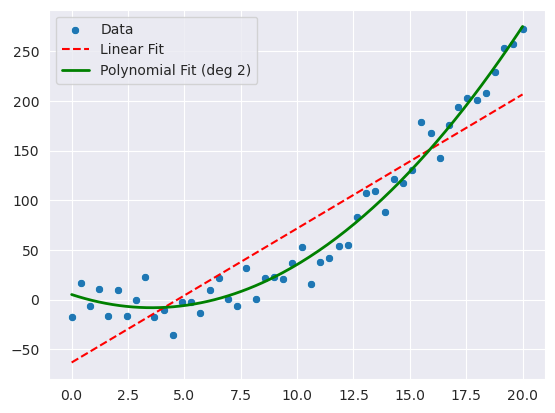

In [4]:
x = np.linspace(0, 20, 50)
y = x**2 - 6 * x - 3 + np.random.randn(50) * 15
X = x.reshape(-1, 1)
x_plot = np.linspace(0, 20, 200).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_plot, y_reg_line, label="Linear Fit", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial Fit (deg 2)", color="green", linewidth=2)
plt.legend()
plt.show()

Test

In [5]:
from linear_models import RobustRegression

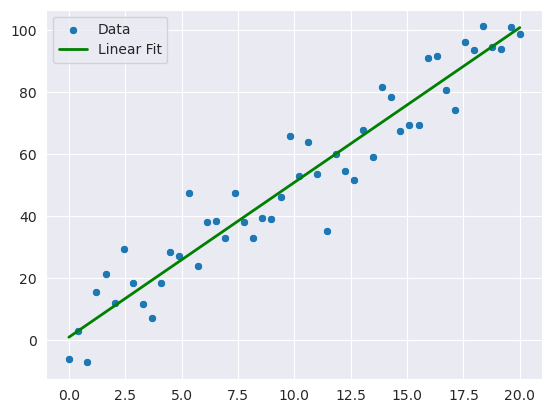

In [6]:
x = np.linspace(0, 20, 50)
y = 5 * x + 3 + np.random.randn(50) * 9

mdl = RobustRegression().fit(x.reshape(-1, 1), y)
x_reg_line = np.linspace(0, 20, 200)
y_reg_line = x_reg_line.reshape(-1, 1) @ mdl.coef_ + mdl.intercept_

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_reg_line, y_reg_line, label="Linear Fit", color="green", linewidth=2)
plt.legend()
plt.show()


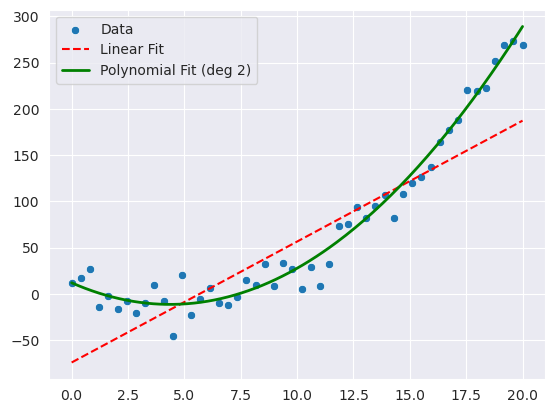

In [7]:
x = np.linspace(0, 20, 50)
y = x**2 - 6 * x - 3 + np.random.randn(50) * 20
X = x.reshape(-1, 1)
x_plot = np.linspace(0, 20, 200).reshape(-1, 1)

mdl1 = RobustRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=2), RobustRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_plot, y_reg_line, label="Linear Fit", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial Fit (deg 2)", color="green", linewidth=2)
plt.legend()
plt.show()


In [8]:
from linear_models import RidgeRegression

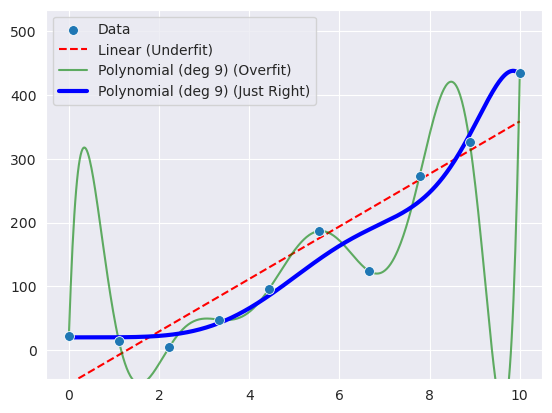

In [9]:
np.random.seed(70)
x = np.linspace(0, 10, 10)
y = 4 * x**2 + 6 * x - 3 + np.random.randn(10) * 30
X = x.reshape(-1, 1)
x_plot = np.linspace(0,10, 500).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=9), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

mdl3 = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), RidgeRegression(alpha=1e5))
mdl3.fit(X, y)
y_reg_line3 = mdl3.predict(x_plot)


sns.scatterplot(x=x, y=y, label="Data", s=50, zorder=5)
plt.plot(x_plot, y_reg_line, label="Linear (Underfit)", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial (deg 9) (Overfit)", color="green", alpha=0.6)
plt.plot(x_plot, y_reg_line3, label="Polynomial (deg 9) (Just Right)", color="blue", linewidth=3)
plt.legend()
plt.ylim(min(y)-50, max(y)+100)
plt.show()

## Lasso Regression

For Lasso Regression we assume a Gaussian Likelihood
$$p(y_i \mid f_w(x_i), \beta) = \mathcal{N}(y_i \mid f_w(x_i), \beta^{-1})$$
where $\beta$ is the precision (inverse variance)
and a Laplace Prior
$$p(w_j \mid \alpha) = \text{Laplace}(w_j \mid 0, \alpha^{-1}) = \frac{\alpha}{2} \exp(-\alpha |w_j|)$$
Assuming the weights are iid (we do this here as this is the same as choosing an isotropic covariance matrix for the multivariate laplacian.
Which we need to get the L1-Normalization. This assumption of course doesn't allow for more elaborate priors, which we could have used if we
derived it with a Multivariate Laplacian and a general covariance matrix.)
$$p(w \mid \alpha) = \prod_{j=1}^{D} p(w_j \mid \alpha)$$
Using Bayes' Theorem, the posterior distribution is:
$$p(\mathbf{w} \mid \mathbf{X}, \mathbf{y}, \beta, \alpha) \propto p(\mathbf{y} \mid \mathbf{X}, \mathbf{w}, \beta) \cdot p(\mathbf{w} \mid \alpha)$$
To find the optimal weights $\hat{\mathbf{w}}$, we minimize the negative log-posterior, since we are doing a MAP estimation:
$$\begin{align*}
\hat{\mathbf{w}} &= \arg\min_{\mathbf{w}} -\log p(\mathbf{w} \mid \mathbf{X}, \mathbf{y}, \beta, \alpha) \\
&= \arg\min_{\mathbf{w}} -\sum_{i=1}^{N} \log \mathcal{N}(y_i \mid \mathbf{w}^\top \mathbf{x}_i, \beta^{-1}) - \sum_{j=1}^{D} \log \text{Laplace}(w_j \mid 0, \alpha^{-1})
\end{align*}$$
Substitutin the PDFS and dropping constants independent of $\mathbf{w}$ we get:
$$\begin{align*}
\hat{\mathbf{w}} &= \arg\min_{\mathbf{w}} \sum_{i=1}^{N} \frac{\beta}{2} (y_i - \mathbf{w}^\top \mathbf{x}_i)^2 + \sum_{j=1}^{D} \alpha |w_j|
\end{align*}$$
So let's define the Lasso Loss functions as follows, defining $\lambda = \frac{\alpha}{\beta}$:
$$E_{\text{Lasso}}(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^{N} (y_i - \mathbf{w}^\top \mathbf{x}_i)^2 + \lambda \sum_{j=1}^{D} |w_j|$$
Now we can optimize this via Coordinate Descent.
Since the $L_1$ penalty is not differentiable at $w_j = 0$, we use subgradients to find the update rule for a single weight $w_j$, keeping all other weights $\mathbf{w}_{k \neq j}$ fixed.
Let the partial residual for the $j$-th feature be:
$$p_j = \sum_{i=1}^{N} x_{ij} \left( y_i - \sum_{k \neq j} w_k x_{ik} \right)$$
The optimality condition $\frac{\partial E}{\partial w_j} = 0$ leads to three cases
1. Case $w_j > 0$: $-p_j + w_j \sum_{i=1}^N x_{ij}^2 + \lambda = 0 \implies w_j = \frac{p_j - \lambda}{\sum x_{ij}^2} \quad (\text{if } p_j > \lambda)$
2. Case $w_j < 0$: $-p_j + w_j \sum_{i=1}^N x_{ij}^2 - \lambda = 0 \implies w_j = \frac{p_j + \lambda}{\sum x_{ij}^2} \quad (\text{if } p_j < -\lambda)$
3. Case $w_j = 0$: The subgradient includes zero if $|p_j| \leq \lambda$.

Combining these cases, the update rule for $w_j$ is given by the soft thresholding function:
$$w_j = \frac{S(p_j, \lambda)}{\sum_{i=1}^N x_{ij}^2}$$
where
$$S(p_j, \lambda) = \text{sign}(p_j) \cdot \max(0, |p_j| - \lambda)$$





In [10]:
from linear_models import LassoRegression

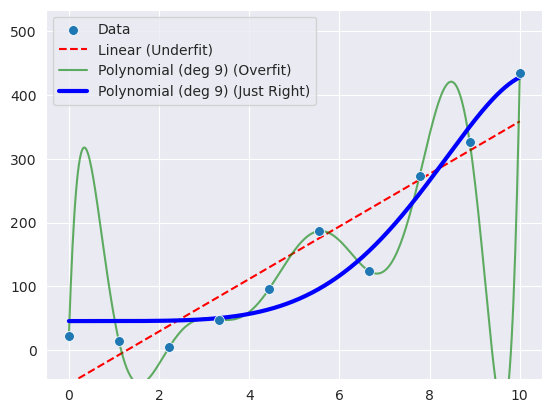

In [11]:
np.random.seed(70)
x = np.linspace(0, 10, 10)
y = 4 * x**2 + 6 * x - 3 + np.random.randn(10) * 30
X = x.reshape(-1, 1)
x_plot = np.linspace(0,10, 500).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=9), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

mdl3 = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), LassoRegression(lmbda=1e5))
mdl3.fit(X, y)
y_reg_line3 = mdl3.predict(x_plot)


sns.scatterplot(x=x, y=y, label="Data", s=50, zorder=5)
plt.plot(x_plot, y_reg_line, label="Linear (Underfit)", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial (deg 9) (Overfit)", color="green", alpha=0.6)
plt.plot(x_plot, y_reg_line3, label="Polynomial (deg 9) (Just Right)", color="blue", linewidth=3)
plt.legend()
plt.ylim(min(y)-50, max(y)+100)
plt.show()


## L4 Regression

For L4 Regression, we again assume a Gaussian as a Likelihood:
$$p(y_i \mid x_i, w, \beta) = \mathcal{N}(y_i \mid w^\top x_i, \beta^{-1})$$
So
$$p(y \mid X, w, \beta) = \prod_{i=1}^{N} \sqrt{\frac{\beta}{2\pi}} \exp\left( -\frac{\beta}{2} (y_i - w^\top x_i)^2 \right)$$
For the Prior we assume a Generalized Normal Distribution with shape parameter p = 4
$$p(w_j \mid \alpha) = \frac{4\alpha}{2\Gamma(1/4)} \exp\left( -\alpha^4 |w_j|^4 \right)$$
Again we assume that the weights are iid (for the same reason as with Lasso Regression):
$$p(w \mid \alpha) = \prod_{j=1}^{D} p(w_j \mid \alpha)$$

Then performing MAP estimation again, we get the posterior distribution through the Bayesian Rule:
$$p(w \mid X, y, \beta, \alpha) \propto p(y \mid X, w, \beta) \cdot p(w \mid \alpha)$$
Taking the negative log-posterior to find the minimum:
$$\hat{w} = \arg\min_{w} \left[ -\log p(y \mid X, w, \beta) - \log p(w \mid \alpha) \right]$$
Substituting the densities and dropping terms that do not depend on w, we get:
$$\hat{w} = \arg\min_{w} \left[ \sum_{i=1}^{N} \frac{\beta}{2} (y_i - w^\top x_i)^2 + \sum_{j=1}^{D} \alpha^4 w_j^4 \right]$$
Dividing by $\beta$ and letting $\lambda = \frac{\alpha^4}{\beta}$
$$E_{L_4}(w) = \frac{1}{2} \|y - Xw\|_2^2 + \lambda \|w\|_4^4$$
Finding the Gradient to use the L-BFGS-B Algorithm, we get:
$$\nabla E(w) = X^T X w - X^T y + 4 \lambda^3$$




In [12]:
from linear_models import L4Regression

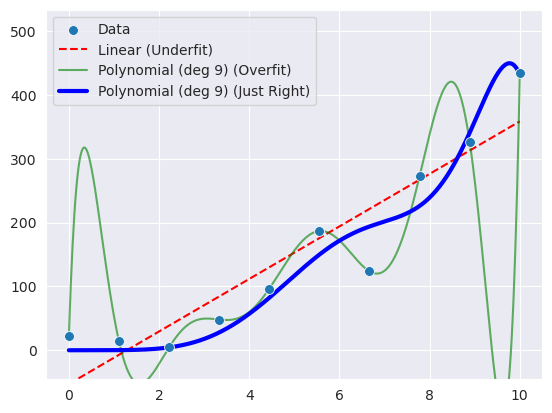

In [13]:
np.random.seed(70)
x = np.linspace(0, 10, 10)
y = 4 * x**2 + 6 * x - 3 + np.random.randn(10) * 30
X = x.reshape(-1, 1)
x_plot = np.linspace(0,10, 500).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=9), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

mdl3 = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), L4Regression(lmbda=1e5))
mdl3.fit(X, y)
y_reg_line3 = mdl3.predict(x_plot)


sns.scatterplot(x=x, y=y, label="Data", s=50, zorder=5)
plt.plot(x_plot, y_reg_line, label="Linear (Underfit)", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial (deg 9) (Overfit)", color="green", alpha=0.6)
plt.plot(x_plot, y_reg_line3, label="Polynomial (deg 9) (Just Right)", color="blue", linewidth=3)
plt.legend()
plt.ylim(min(y)-50, max(y)+100)
plt.show()


In [14]:
from linear_models import PoissonRegression

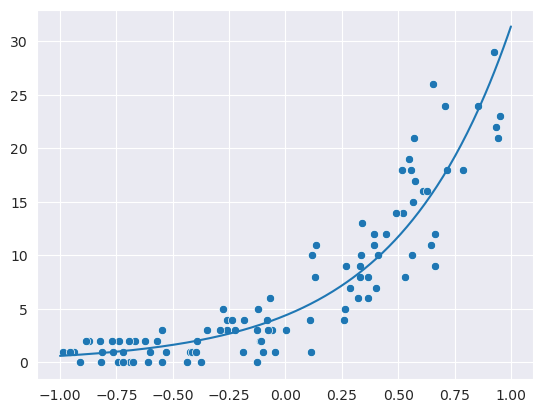

In [20]:
rng = np.random.default_rng(42)
X = rng.uniform(-1, 1, (100, 1))

z = X @ np.array([2]) + 1.5
mu = np.exp(z)
y = rng.poisson(mu).flatten()

x_plot = np.linspace(-1, 1, 300).reshape(-1, 1)

mdl1 = PoissonRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

sns.scatterplot(x=X.flatten(), y=y)
plt.plot(x_plot, y_reg_line)